# <center>HW 3 Solutions</center>
<center>DATA 558, Spring 2021</center>


In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## Exercise 1

    (a) As $\lambda$ decreases from $\lambda_{max}$ to 0, the misclassification error on the training set will:
        - (ii) Steadily decrease.
Performance on the training set is optimized in the zero-penalty case, as that corresponds to selecting the model that *best* explains the observed data. Increasing penalization results in decreasing goodness-of-fit on the training data. Thus the worst performance on the training set occurs at lambda_max, and the best occurs at lambda=0.
        
      
      
    (b) As $\lambda$ decreases from $\lambda_{max}$ to 0, the misclassification error on the test set will:
        - (iv) Decrease, then increase.

At high values of the penalty, the parameter estimate is so constrained that it is unlikely to be a good fit to either the train or test sets - in the extreme case, the parameter is essentially zero. On the other hand, when the penalty is close to zero there is barely any constraint on the variance of the estimated model, and overfitting is likely to occur. In between these two cases, we expect that there is some range of penalization for which the increase in bias is more than offset by the decrease in variance, with an overall favorable effect on the MSE of the estimated model.

## Exercise 2

    (a)-(b): Gradient computations.
    
    

- Assume that d=1 and n=1. The function $F$ writes simply as
\begin{equation}
F(\beta) = \log(1+\exp(-y x \,\beta) \; + \lambda \beta^2 \; .
\end{equation}
Compute and write down the gradient $\nabla F$ of $F$. 

__Solution:__ 
$$
\nabla F(\beta) = -yx \frac{\exp(-yx\beta)}{1+\exp(-yx\beta)} + 2\lambda \beta
$$ 

- Assume now that  $d>1$ and $n>1$. Using the previous result and the linearity of differentiation, compute and write down the gradient $\nabla F(\beta)$ of $F$. 

__Solution:__

$$\nabla F = \frac{1}{n}\sum_{i=1}^n -y_i x_i \frac{\exp(-y_i x_i^T\beta)}{1+\exp(-y_i x_i^T\beta)} + 2\lambda \beta.$$

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

    (c)-(d) Load and process smarket dataset

In [3]:
file = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv(file, sep=',', header=0, index_col=0)

In [4]:
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [5]:
X = smarket[['Lag1', 'Lag2', 'Volume']]
y = np.array([1 if x=='Up' else -1 for x in smarket['Direction']])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_train.mean(axis=0)

array([ -1.24344979e-17,   2.48689958e-17,   2.46913601e-16])

In [9]:
X_train.std(axis=0)

array([ 1.,  1.,  1.])

    (e). Write computegrad function (plus logistic regression objective)

Recall the penalized logistic regression objective is:

$$
\ell(\beta) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^T\beta)) + \lambda ||\beta||_2^2
$$

In [10]:
def objective(beta, lam, X=X_train, y=y_train):
    n = len(y)
    return (1/n)*np.sum(np.log(1 + np.exp(-y*X.dot(beta)))) + lam*np.linalg.norm(beta)**2

and the gradient is:

$$
\nabla_\beta \ell = -\frac{1}{n} \sum_{i=1}^n -y_i x_i \frac{\exp(-y_i x_i^T\beta)}{1 + \exp(-y_i x_i^T\beta)} + 2 \lambda \beta
$$

which can be written in matrix form as 

$$
\nabla_\beta \ell = -\frac{1}{n} X^T Q Y
$$

with 
$$
Q = \text{diag}\left(\frac{\exp(-y_i x_i^T\beta)}{1 + \exp(-y_i x_i^T\beta)}\right)
$$

In [11]:
# sum version
def computegrad_v1(beta, lam, X=X_train, y=y_train):
    yx = y[:, np.newaxis]*X
    denom = 1+np.exp(-yx.dot(beta))
    grad = 1/len(y)*np.sum(-yx*np.exp(-yx.dot(beta[:, np.newaxis]))/denom[:, np.newaxis], axis=0) + 2*lam*beta
    return grad

In [12]:
# matrix version
def Q_mat(X, y, beta):
    yx = y[:, np.newaxis]*X
    Qvec_denom = 1+np.exp(-yx.dot(beta))
    Qvec_num = np.exp(-yx.dot(beta))
    Qvec = Qvec_num / Qvec_denom
    return np.diag(Qvec)

def computegrad(beta, lam, X=X_train, y=y_train):
    n = len(y)
    Q = Q_mat(X, y, beta)
    return (-1/n)*np.dot(X.T, np.dot(Q, y)) + 2*lam*beta

In [13]:
# implementations are equivalent
d = X_train.shape[1]
n = X_train.shape[0]
beta = np.random.normal(size=d)

computegrad_v1(beta, 100.0)

array([ 130.43910811, -189.5750977 ,  -91.20115302])

In [14]:
computegrad(beta, 100.0)

array([ 130.43910811, -189.5750977 ,  -91.20115302])

    (f) Write backtracking method

In [15]:
def backtracking(beta, lam, eta=1, alpha=0.5, betaparam=0.8, maxiter=100, X=X_train, y=y_train):
    grad_beta = computegrad(beta, lam, X=X, y=y) # initialize
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_eta = 0
    num_iters = 0
    
    while found_eta == 0 and num_iters < maxiter: # loop until we find a good step size (or take too long)
        
        # take a step and evaluate the objective
        obj_step = objective(beta - eta*grad_beta, lam, X=X, y=y)
        
        # RHS of sufficient decrease criterion
        decrease_thresh = objective(beta, lam, X=X, y=y) - alpha*eta*norm_grad_beta**2
        
        if obj_step < decrease_thresh: # check criterion
            found_eta = 1 # if satisfied, return step size
        elif num_iters == maxiter:
            raise('Max number of iterations of backtracking line search reached')
        else:
            eta*= betaparam # if not (and below max_iter), decrease step size
            num_iters += 1
            
    return eta

    (g) Write gradient descent with backtracking

In [16]:
def graddescent(beta_init, lam, eta_init, X=X_train, y=y_train, eps=5.1**-3):
    beta = beta_init # initialize
    grad_beta = computegrad(beta, lam, X=X, y=y)
    beta_vals = beta
    num_iters = 0
    
    while np.linalg.norm(grad_beta) > eps: # use gradient norm stop criterion
        eta = backtracking(beta, lam, eta=eta_init, X=X, y=y) # find step size
        beta = beta - eta*grad_beta # take a step
        beta_vals = np.vstack((beta_vals, beta)) 
        grad_beta = computegrad(beta, lam, X=X, y=y)
        num_iters += 1
        
    return beta_vals

    (h) Write accelerated gradient descent (i.e. fast gradient algorithm)

In [17]:
def fastgradalgo(beta_init, theta_init, lam, eta, X=X_train, y=y_train, eps=5.1**-3):
    beta = beta_init # initialize beta and theta
    theta = theta_init
    grad_theta = computegrad(theta, lam, X=X, y=y)
    grad_beta = computegrad(beta, lam, X=X, y=y)
    beta_vals = beta
    theta_vals = theta
    num_iters = 0
    
    while np.linalg.norm(grad_beta) > eps: # use gradient norm stop criterion
        
        eta = backtracking(theta, lam, eta=eta, X=X, y=y) # first find step size
        
        beta_new = theta - eta*grad_theta # step in beta, from previous theta
        theta = beta_new + num_iters/(num_iters+3)*(beta_new-beta) # extrapolation step in theta
        
        beta_vals = np.vstack((beta_vals, beta)) # update each
        theta_vals = np.vstack((theta_vals, theta))
        
        grad_theta = computegrad(theta, lam, X=X, y=y) # get gradient at new points
        grad_beta = computegrad(beta, lam, X=X, y=y)
        beta = beta_new
        num_iters += 1
        
    return beta_vals

    (i) Run both gradient descent algs

In [42]:
lam = 0.5

d = X.shape[1]
beta_init = np.zeros(d)
theta_init = np.zeros(d)

eta_init = 0.1
maxiter = 1000

betas_grad = graddescent(beta_init, lam, eta_init, eps=1e-5)
betas_fastgrad = fastgradalgo(beta_init, theta_init, lam, eta_init, eps=1e-5)

In [43]:
GD_obj_trace = [objective(x, lam) for x in betas_grad]
AGD_obj_trace = [objective(x, lam) for x in betas_fastgrad]

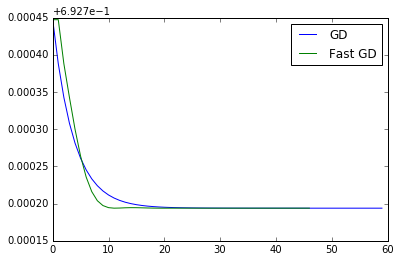

In [44]:
plt.plot(GD_obj_trace, label='GD')
plt.plot(AGD_obj_trace, label='Fast GD')
plt.legend()
plt.show()

In [45]:
GD_obj_trace[-1]

0.69289385537089065

In [46]:
AGD_obj_trace[-1]

0.69289385533364245

    (j) Compare to sklearn

In [23]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

n = X_train.shape[0]
skcoef = LogisticRegression(C = 1/(2*n*lam)).fit(X_train, y_train).coef_

In [24]:
# compare parameters
print('sklearn params: {}'.format(skcoef))
print('GD params: {}'.format(betas_grad[-1]))
print('FGD params: {}'.format(betas_fastgrad[-1]))

sklearn params: [[-0.01412447 -0.01258223  0.00702304]]
GD params: [-0.01411871 -0.01257774  0.00702096]
FGD params: [-0.01412273 -0.01258201  0.00702339]


In [25]:
# compare objectives
print('sklearn objective: {:.6f}'.format(objective(skcoef[0,:], lam)))
print('GD objective: {:.6f}'.format(objective(betas_grad[-1], lam)))
print('FGD objective: {:.6f}'.format(objective(betas_fastgrad[-1], lam)))

sklearn objective: 0.692894
GD objective: 0.692894
FGD objective: 0.692894


    (k) Find best $\lambda$ with LogisticRegressionCV()

In [26]:
cvres = LogisticRegressionCV(Cs=30).fit(X_train,y_train)

In [27]:
C = cvres.C_[0]
C

1.3738237958832638

In [28]:
lam = 1/(2*n*C) # convert to our lambda
lam

0.0003639476921991573

In [29]:
d = X.shape[1]
beta_init = np.zeros(d)
theta_init = np.zeros(d)

eta_init = 0.1
maxiter = 1000

betas_grad = graddescent(beta_init, lam, eta_init, eps=1e-5)
betas_fastgrad = fastgradalgo(beta_init, theta_init, lam, eta_init, eps=1e-5)

In [30]:
GD_obj_trace = [objective(x, lam) for x in betas_grad]
AGD_obj_trace = [objective(x, lam) for x in betas_fastgrad]

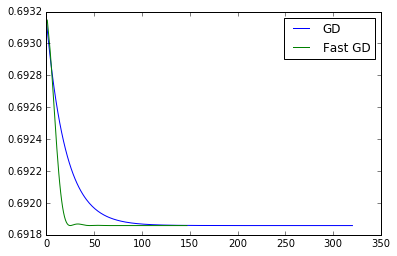

In [31]:
plt.plot(GD_obj_trace, label='GD')
plt.plot(AGD_obj_trace, label='Fast GD')
plt.legend()
plt.show()

In [32]:
def get_model_preds(X, betas):
    xtb = np.dot(X, betas)
    probs = 1 / (1+np.exp(-xtb))
    preds = (probs > 0.5)*2-1 # convert preds to +/- 1
    return probs, preds

def acc(preds, truth):
    return np.mean(preds==truth)

In [33]:
lr = LogisticRegression(C = 1/(2*n*lam), fit_intercept=False).fit(X_train, y_train)

In [34]:
prob, pred = get_model_preds(X_train, lr.coef_[0,:])
lrpred = lr.predict(X_train)
np.mean(pred==lrpred) # compare our prediction method to scikit-learn 

1.0

In [48]:
gd_acc = [acc(get_model_preds(X_train, b)[1], y_train) for b in betas_grad]
agd_acc = [acc(get_model_preds(X_train, b)[1], y_train) for b in betas_fastgrad]

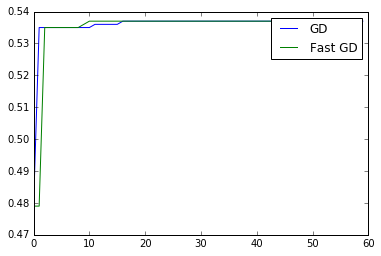

In [49]:
plt.plot(gd_acc, label='GD') 
plt.plot(agd_acc, label='Fast GD')
plt.legend()
plt.show()

In [ ]:
# NOTE: for misclassification error, plot 1-(accuracy)

In [37]:
# why is this so bad? 2 reasons: 
# (1) we didn't fit an intercept, and that has a negative impact on prediction quality
# ---  could fix this by amending the objective and gradient above (but don't penalize the intercept!)
# (2) there's basically no signal in the market history alone regarding its future movement 
# ---  see definition of "martingale"